# Problem Set #1
### MACS 30250, Dr. Evans
### Ruixi Li

In [1]:
import numpy as np
import pandas as pd
import random

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib notebook

from scipy.stats import gaussian_kde
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

import multiprocessing
from dask import compute, delayed
import dask.multiprocessing
import timeit

import warnings
warnings.filterwarnings("ignore")

## Question 1

#### (a)

In [2]:
# Import the rough bequest distribution matrix and transpose it
bq_data = np.loadtxt('data/BQmat_orig.txt', delimiter=',')

# Some diagnostics
print('Shape of bq_data', bq_data.shape)
print('Bequest distribution by income group:',
      bq_data.sum(axis=0))
print('Bequest distribution by age group:',
      bq_data.sum(axis=1))
print('Sum of all probabilities', bq_data.sum())

Shape of bq_data (78, 7)
Bequest distribution by income group: [0.01214584 0.00817072 0.01590964 0.0139963  0.01383075 0.06927237
 0.86667437]
Bequest distribution by age group: [8.86582658e-04 5.70017321e-04 1.22808428e-02 6.89456419e-04
 2.13752835e-04 3.07249416e-03 2.15844659e-03 1.14127672e-03
 9.77767430e-03 1.25006312e-02 7.32933120e-03 8.90001319e-03
 4.36423812e-03 8.79963316e-03 5.31438054e-03 7.46667436e-03
 9.86805613e-03 1.24892682e-02 4.88834783e-03 5.27214505e-03
 3.58273277e-02 1.16728805e-02 1.02956537e-02 1.09182048e-02
 2.34851553e-02 1.87283522e-02 3.93666749e-02 1.87449101e-02
 4.88500163e-02 1.59935003e-02 2.43528902e-02 2.56744256e-02
 1.56556262e-02 5.09342207e-02 2.04055385e-02 1.57812659e-02
 4.72762613e-02 1.76250983e-02 2.83611980e-02 1.34761987e-02
 6.12574170e-02 2.41355622e-02 1.98039177e-02 2.21873164e-02
 3.56284346e-02 4.49420967e-02 1.14887709e-02 2.83048159e-02
 8.92448997e-03 1.13632467e-02 1.59677078e-02 1.39055369e-02
 6.78948218e-03 1.92259141e-0

1.0


Text(0.5, 0, 'Percent of BQ received')

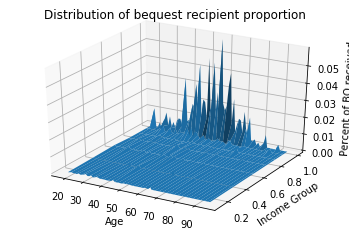

In [3]:
# Because the sum of all probabilities is not exactly equal
# to 1.0, I rescale the matrix.
BQ_mat = bq_data / bq_data.sum()
print(BQ_mat.sum())

# Make 3D surface plot of rough bequests distribution matrix
age_vec = np.arange(18, 96)
income_vec = np.array([0.25, 0.25, 0.20, 0.10, 0.10, 0.09, 0.01])
income_mdpts = np.array([0.125, 0.375, 0.60, 0.75, 0.85,
                          0.94, 0.995])
income_mat, age_mat = np.meshgrid(income_mdpts, age_vec)

fig = plt.figure()
ax = fig.gca(projection='3d')
ax.plot_surface(age_mat, income_mat, BQ_mat)
ax.set_title('Distribution of bequest recipient proportion')
ax.set_xlabel('Age')
ax.set_ylabel('Income Group')
ax.set_zlabel('Percent of BQ received')

#### (b)

In [4]:
ages_vec = np.arange(18, 96)
income_vec = np.array([0.25, 0.25, 0.20, 0.10, 0.10, 0.09, 0.01])
income_mdpts = np.array([0.125, 0.375, 0.60, 0.75, 0.85, 0.94, 0.995])
income_prob_mat = np.sum(bq_data, axis=0)
age_prob_mat = np.sum(bq_data, axis=1)

N_samp = 70000
age_probs = np.random.multinomial(N_samp, age_prob_mat)
income_probs = np.random.multinomial(N_samp, income_prob_mat)

age_freq = np.array([])
inc_freq = np.array([])
# creating a distribution of age values
for age, num_s in zip(ages_vec, age_probs):
    vec_age_s = np.ones(num_s)
    vec_age_s *= age
    age_freq = np.append(age_freq, vec_age_s)
# creating a distribution of ability type values
for abil, num_j in zip(income_mdpts, income_probs):
    vec_abil_j = np.ones(num_j)
    vec_abil_j *= abil
    inc_freq = np.append(inc_freq, vec_abil_j)

1.0


Text(0.5, 0, 'Percent of BQ received')

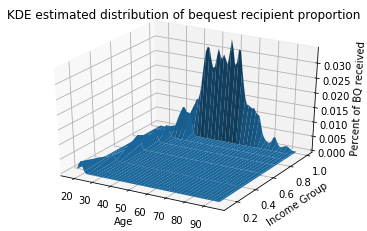

In [5]:
bandwidth = 0.1 # lambda
data = np.vstack((age_freq, inc_freq))
density = gaussian_kde(data, bw_method=bandwidth)
coords = np.vstack([item.ravel() for item in [age_mat, income_mat]])
BQkde = density(coords).reshape(age_mat.shape)

# Because the sum of all probabilities is not exactly equal
# to 1.0, I rescale the matrix.
BQkde_scaled = BQkde / BQkde.sum()
print(BQkde_scaled.sum())

# Make 3D surface plot of rough bequests distribution matrix
age_vec = np.arange(18, 96)
income_vec = np.array([0.25, 0.25, 0.20, 0.10, 0.10, 0.09, 0.01])
income_mdpts = np.array([0.125, 0.375, 0.60, 0.75, 0.85, 0.94, 0.995])
income_mat, age_mat = np.meshgrid(income_mdpts, age_vec)

fig = plt.figure()
ax = fig.gca(projection='3d')
ax.plot_surface(age_mat, income_mat, BQkde_scaled)
ax.set_title('KDE estimated distribution of bequest recipient proportion')
ax.set_xlabel('Age')
ax.set_ylabel('Income Group')
ax.set_zlabel('Percent of BQ received')

By alternating bandwidth, I find that $\lambda = 0.1$ seems to fit best since it gives smoother surface and close to data.

In [6]:
BQkde_scaled[43][5]

1.2838726087053706e-06

Estimated density for bequest recipients who are age 61 in the 6th lifetime income category is 1.28.

## Question 2

In [7]:
df = pd.read_csv('data/Auto.csv',na_values = "?")
df.dropna(inplace=True)

Median = df['mpg'].median()
df['mpg_high'] = 0
df.mpg_high[df['mpg'] >= Median] = 1

df['orgn1'] = 0
df.orgn1[df['origin'] == 1] = 1
df['orgn2'] = 0
df.orgn2[df['origin'] == 2] = 1

df.head()

,mpg,cylinders,displacement,horsepower,weight,acceleration,year,origin,name,mpg_high,orgn1,orgn2
0,18.0,8,307.0,130.0,3504,12.0,70,1,chevrolet chevelle malibu,0,1,0
1,15.0,8,350.0,165.0,3693,11.5,70,1,buick skylark 320,0,1,0
2,18.0,8,318.0,150.0,3436,11.0,70,1,plymouth satellite,0,1,0
3,16.0,8,304.0,150.0,3433,12.0,70,1,amc rebel sst,0,1,0
4,17.0,8,302.0,140.0,3449,10.5,70,1,ford torino,0,1,0


#### (a)

In [8]:
y = df['mpg_high'].values
X = df[['cylinders', 'displacement', 'horsepower', 'weight', 'acceleration', 'year', 'orgn1', 'orgn2']].values

start_time = timeit.default_timer()
MSE = []
for i in range(100):
    MSE_part = []
    for j in range(i+1):
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.35, random_state=i+j+1)
        LogReg = LogisticRegression(n_jobs=1) # set n_jobs to 1 to guarantee that it runs in serial
        LogReg.fit(X_train, y_train)
        y_pred = LogReg.predict(X_test)
        MSE_now = ((y_test - y_pred) ** 2).mean()
        MSE_part.append(MSE_now)
    MSE.append(np.array(MSE_part).mean())
MSE_avg = np.array(MSE).mean()
elapsed_time = timeit.default_timer() - start_time
print('The error rate is ', MSE_avg)
print('The computation takes ', elapsed_time, 'seconds')

The error rate is  0.10183897075010881
The computation takes  10.676608443987789 seconds


#### (b)

In [9]:
# First let's check how many cores we have available
num_cores = multiprocessing.cpu_count()
print('Number of available cores is', num_cores)

def paral(bootstrap_num, seed, data):
    MSE = []
    for i in range(bootstrap_num):
        X, y = data
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.35, random_state=seed+i)
        LogReg = LogisticRegression(n_jobs=1) # set n_jobs to 1 to guarantee that it runs in serial
        LogReg.fit(X_train, y_train)
        y_pred = LogReg.predict(X_test)
        MSE_now = ((y_test - y_pred) ** 2).mean()
        MSE.append(MSE_now)
    return np.array(MSE).mean()

start_time2 = timeit.default_timer()
MSE2 = []
for i in range(100):
    MSE2.append(delayed(paral)(i + 1, i + 1, [X, y]))
results_par = compute(*MSE2, scheduler=dask.multiprocessing.get, num_workers=num_cores)
MSE2_avg = np.array(results_par).mean()
elapsed_time2 = timeit.default_timer() - start_time2
print('The error rate from this parallelized list of error rates is ', MSE2_avg)
print('The computation takes ', elapsed_time2, 'seconds')

Number of available cores is 4
The error rate from this parallelized list of error rates is  0.10183897075010881
The computation takes  4.938318726999569 seconds
